In [57]:
import scanpy as sc
import scipy
from scipy.sparse import issparse, csr_matrix
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import gc
import psutil
from typing import Optional, Tuple, Dict, Any
import logging

# configre logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [ ]:
# load corrected and uncorrected data
adata_corrected = sc.read_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/aging_all_2024/objects/cellbender_corrected_ref.h5ad')
adata_uncorrected = sc.read_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/aging_all_2024/objects/major_celltype_updated_ref.h5ad')

In [ ]:
adata_corrected

In [ ]:
adata_uncorrected

In [ ]:
dup_mask = adata_corrected.obs.index.duplicated(keep=False)

# Extract duplicated barcodes and their counts
duplicates = adata_corrected.obs.index[dup_mask]
duplicate_cells = duplicates.value_counts()

print("Number of duplicated barcodes in corrected data:", len(duplicate_cells))
print(duplicate_cells)
#find if common genes is unique in index object
unique_genes_corrected = adata_corrected.var.index.unique()
print(f"Unique genes in corrected data: {len(unique_genes_corrected)}")

In [ ]:
# Keep only the last part after the last "_"
adata_uncorrected.obs.index = adata_uncorrected.obs.index.str.rsplit("_", n=1).str[-1]

In [ ]:
for ad in (adata_uncorrected, adata_corrected):
    # Ensure string dtype
    ad.obs_names = ad.obs_names.astype(str)
    ad.var_names = ad.var_names.astype(str)
    # Remove duplicates by appending -1, -2, ...
    ad.obs_names_make_unique()
    ad.var_names_make_unique()

#### Subset to the same cells and genes and transfer metadata from cellbender to the combined adata

In [ ]:
# find overlapping cells
common_cells = adata_uncorrected.obs.index.intersection(adata_corrected.obs.index)
common_genes = adata_uncorrected.var.index.intersection(adata_corrected.var.index)
print(f"Found {len(common_cells)} common cells")
print(f"Found {len(common_genes)} common genes")

In [ ]:
adata_orig_subset = adata_uncorrected[common_cells, common_genes].copy()
adata_corrected_subset = adata_corrected[common_cells, common_genes].copy()

In [ ]:
# copy over all processed data
adata_combined = adata_orig_subset.copy()

In [ ]:
# add cellbender counts as layer
adata_combined.layers['cellbender'] = adata_corrected_subset.X.copy()

In [ ]:
print("Transferring cell metadata (obs)...")
for col in adata_corrected_subset.obs.columns:
    if col not in adata_combined.obs.columns:
        # Initialize new column with appropriate dtype
        if adata_corrected_subset.obs[col].dtype == 'object':
            adata_combined.obs[col] = pd.NA
        else:
            adata_combined.obs[col] = np.nan
    
    # Update values for common cells
    adata_combined.obs[col] = adata_corrected_subset.obs[col]

In [ ]:
adata_combined.obs

In [ ]:
# Transfer obsm with logging
print(f"Transferring {len(adata_corrected_subset.obsm.keys())} obsm entries:")
for key in adata_corrected_subset.obsm.keys():
    print(f"  - {key}: {adata_corrected_subset.obsm[key].shape}")
    adata_combined.obsm[key] = adata_corrected_subset.obsm[key].copy()

# Transfer varm with logging
print(f"Transferring {len(adata_corrected_subset.varm.keys())} varm entries:")
for key in adata_corrected_subset.varm.keys():
    print(f"  - {key}: {adata_corrected_subset.varm[key].shape}")
    adata_combined.varm[key] = adata_corrected_subset.varm[key].copy()

# Transfer uns with logging
print(f"Transferring {len(adata_corrected_subset.uns.keys())} uns entries:")
for key in adata_corrected_subset.uns.keys():
    print(f"  - {key}")
    adata_combined.uns[key] = adata_corrected_subset.uns[key]

In [ ]:
adata_combined

In [ ]:
# write combined adata
adata_combined.write_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/aging_all_2024/objects/ref_cellbender_orig_combined.h5ad')

## Check for batch effects between sexes

In [83]:
adata = sc.read_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/aging_all_2024/objects/ref_cellbender_orig_combined.h5ad')

In [85]:
adata

AnnData object with n_obs × n_vars = 39960 × 20500
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'log10GenesPerUMI', 'seurat_clusters', 'RNA_snn_res.0.6', 'cell_type', 'condition', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency'
    var: 'highly_variable'
    uns: 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'harmony', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_curve_test_elbo', 'learning_curve_test_epoch', 'learning_curve_train_elbo', 'learning_curve_train_epoch', 'neighbors', 'pca', 'swapping_fraction_dist_params', 'target_false_positive_rate'
    obsm: 'X_harmony', 'X_pca', 'X_umap', 'gene_expression_encoding'
    varm: 'PCs', 'harmony'
    layers: 'cellbender', 'counts'
    obsp: 'connectivities', 'distances', 'nn', 'snn'

In [86]:
# make a layer for the old normalized counts
adata.layers['norm_old'] = adata.X.copy()

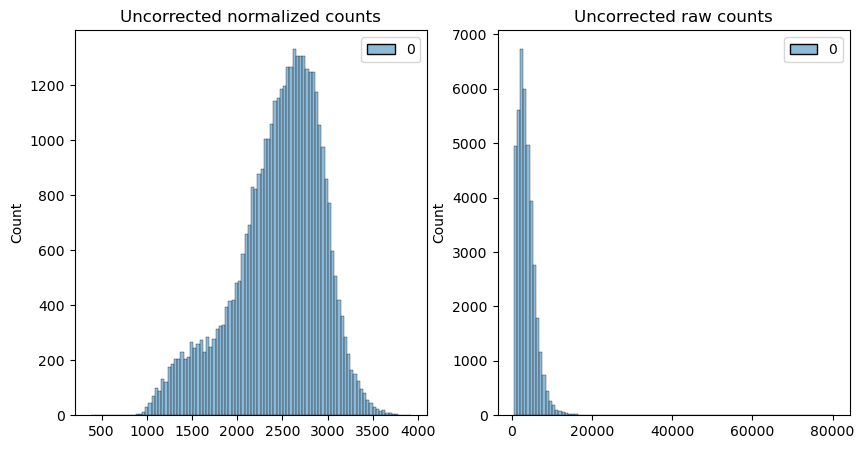

In [89]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.layers["norm_old"].sum(1), bins=100, kde=False, ax=axes[0])
axes[0].set_title("Uncorrected normalized counts")
p2 = sns.histplot(adata.layers["counts"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Uncorrected raw counts")
plt.show()

In [90]:
# Calculate QC metrics
adata.var['mt'] = adata.var_names.str.startswith('mt-')
adata.var['ribo'] = adata.var_names.str.startswith(('rps', 'rpl'))
adata.var["hb"] = adata.var_names.str.contains("^hb[^(p)]")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 39960 × 20500
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'log10GenesPerUMI', 'seurat_clusters', 'RNA_snn_res.0.6', 'cell_type', 'condition', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'highly_variable', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'harmony', 'learning_curve_learning_rate_epoch', 'learning_curve_l

In [91]:
adata.X = adata.layers['cellbender']

In [92]:
# Calculate QC metrics
adata.var['mt_cb'] = adata.var_names.str.startswith('mt-')
adata.var['ribo_cb'] = adata.var_names.str.startswith(('rps', 'rpl'))
adata.var["hb_cb"] = adata.var_names.str.contains("^hb[^(p)]")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt_cb", "ribo_cb", "hb_cb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 39960 × 20500
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'log10GenesPerUMI', 'seurat_clusters', 'RNA_snn_res.0.6', 'cell_type', 'condition', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb'
    var: 'highly_variable', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt_cb', 'ribo_cb', 'hb_cb'
    

In [93]:
# cut off cells to compare cellbender vs uncorrected counts on the same scale
adata = adata[adata.obs['total_counts_mt_cb'] < 50]

/ocean/projects/cis240075p/asachan/.conda/envs/scproc/lib/python3.12/site-packages/scanpy/plotting/_utils.py:482: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


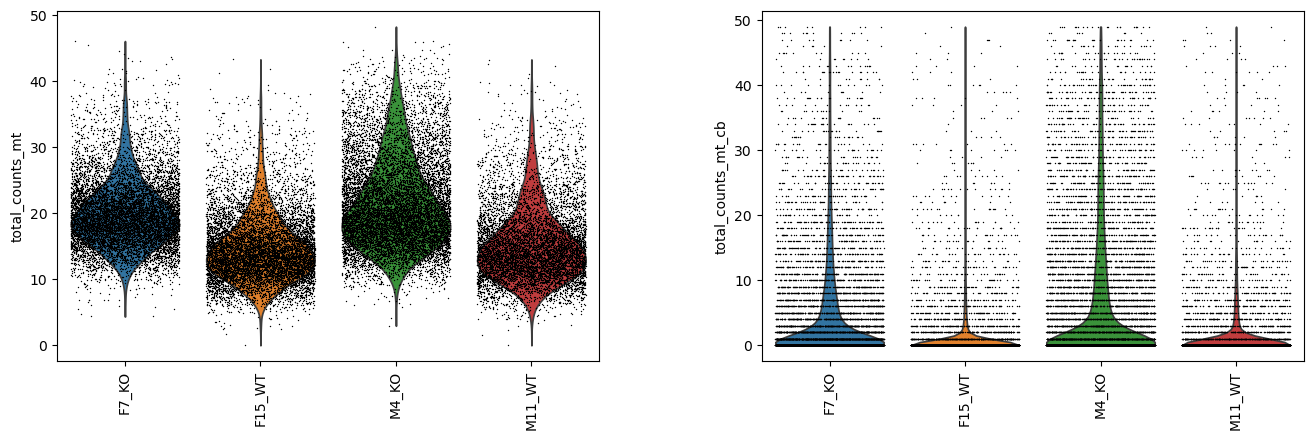

In [94]:
sc.pl.violin(
    adata,
    ["total_counts_mt", "total_counts_mt_cb"],
    groupby='orig.ident',
    jitter=0.4,
    multi_panel=True,
    rotation=90
)

In [95]:
adata.X = adata.layers['cellbender'].copy()
# normalize cellbender counts
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1p_norm_cb"] = sc.pp.log1p(scales_counts["X"], copy=True)

/ocean/projects/cis240075p/asachan/.conda/envs/scproc/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)


#### Filter the cells based on cell-bender probabilities

In [96]:
# get the cells with probability > 0.9
adata = adata[adata.obs['cell_probability'] > 0.99]

In [97]:
adata

View of AnnData object with n_obs × n_vars = 38401 × 20500
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'log10GenesPerUMI', 'seurat_clusters', 'RNA_snn_res.0.6', 'cell_type', 'condition', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb'
    var: 'highly_variable', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt_cb', 'ribo_cb', 'hb_

In [98]:
analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata, inplace=False)
adata.layers["analytic_pearson_residuals"] = csr_matrix(analytic_pearson["X"])

/ocean/projects/cis240075p/asachan/.conda/envs/scproc/lib/python3.12/site-packages/scanpy/experimental/pp/_normalization.py:140: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


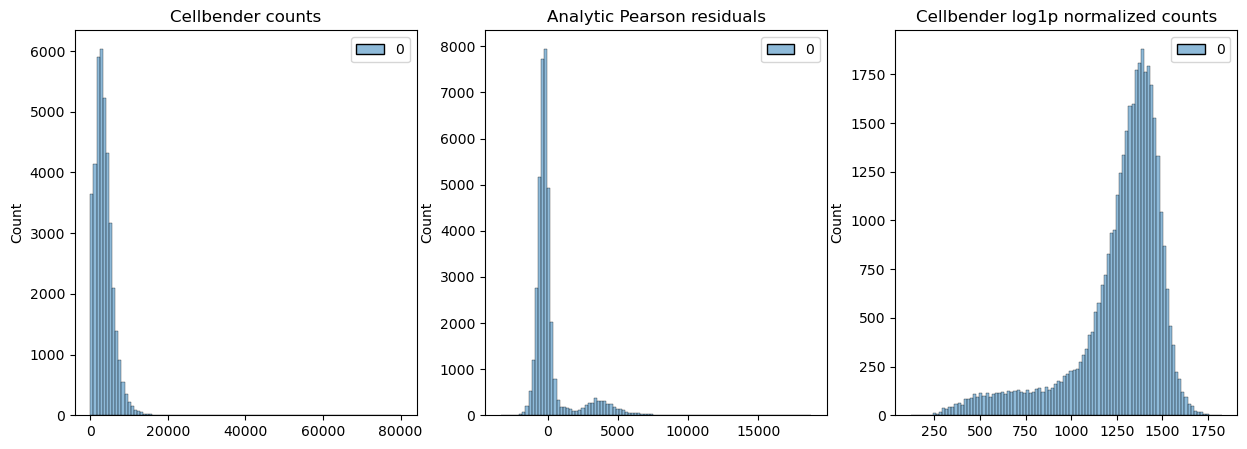

In [101]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
p1 = sns.histplot(
    adata.layers["cellbender"].sum(1), bins=100, kde=False, ax=axes[0]
    )
axes[0].set_title("Cellbender counts")
p2 = sns.histplot(
    adata.layers["analytic_pearson_residuals"].sum(1), bins=100, kde=False, ax=axes[1]
)
axes[1].set_title("Analytic Pearson residuals")
p3 = sns.histplot(
    adata.layers["log1p_norm_cb"].sum(1), bins=100, kde=False, ax=axes[2]
)
axes[2].set_title("Cellbender log1p normalized counts")
plt.show()

In [102]:
# save adata
adata.write_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/aging_all_2024/objects/ref_norm_v2.h5ad')

In [ ]:
marker_genes = [
    "Ano4", "Prkar1a", "Usp1", "Col13a1", "Tnxb", "Egfr", "Gsn",
    "Abi3bp", "Ptprd", "Col22a1", "Adamts20", "App", "Trpc3", "Cacna1c",
    "Slc35f1", "Hs6st3", "Chodl", "Pax7", "Flt1", "Mecom",
    "Dach1", "Pecam1", "F13a1", "Mctp1", "Slc9a9", "Actn3", "Sorbs2", "Xpr1",
    "Myh1", "Kcnn2", "Acss2", "Fhl1"
]

# marker_genes_dict = {
#     "Pericyte": ["Egfr", "Trpc3", "Cacna1c", "Slc35f1", "Myh1"],
#     "EC": ["App", "Flt1", "Mecom", "Dach1", "Pecam1" ],
#     "Tendon": ["Egfr", "Gsn", "Abi3bp", "Ptprd", "Cacna1c", "Myh1"],
#     "FAPs": ["Myh1", "App", "Abi3bp", "Tnxb", "Egfr", "Gsn"],
#     "Macrophages": ["Gsn", "App", "F13a1", "Mctp1", "Slc9a9", "Myh1"],
#     "Skeleton MuSc": ["Egfr", "Ptprd", "Hs6st3", "Chodl", "Pax7", "Myh1"],
#     "Fast IIX": ["Actn3", "Xpr1", "Myh1", "Kcnn2", "Acss2", "Fhl1"],
#     "Fast IIB": ["Actn3", "Sorbs2", "Xpr1", "Myh1", "Kcnn2"],
#     "MTJ": ["Col22a1", "Adamts20", "App", "Actn3", "Sorbs2", "Xpr1", "Myh1", "Acss2", "Fhl1" ],
#     "NMJ": ["Ano4", "Prkar1a", "Col13a1", "Ptprd", "App", "Actn3", "Xpr1", "Myh1", "Acss2", "Fhl1" ]
# }

marker_genes_dict = {
    "Pericyte": marker_genes,
    "EC": marker_genes,
    "Tendon": marker_genes,
    "FAPs": marker_genes,
    "Macrophages": marker_genes,
    "Skeleton MuSc": marker_genes,
    "Fast IIX": marker_genes,
    "Fast IIB": marker_genes,
    "MTJ": marker_genes,
    "NMJ": marker_genes
}

In [ ]:
# plot dotplot of marker genes and cell types
sc.pl.dotplot(adata_combined, marker_genes, groupby='cell_type', show=False)